In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10093033899519972833, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15577238214129514336
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1872625664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3084486855187668924
 physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1210902605573685618
 physical_device_desc: "device: XLA_GPU device"]

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
def load_all_cifar_data():
    folder_path = 'cifar-10-batches-py'
    data = []
    labels = []
    for i in range(1,6):
        batch = unpickle(f'{folder_path}/data_batch_{i}')
        data.append(batch[b'data'])
        labels.append(batch[b'labels'])
    
    return np.concatenate(tuple(data), axis=0), np.concatenate(tuple(labels), axis=0)

In [5]:
data, labels = load_all_cifar_data()

In [6]:
a = np.zeros((50000,10))
a[np.arange(50000), labels] = 1

labels = a
print(data.shape)
print(labels.shape)

(50000, 3072)
(50000, 10)


In [7]:
data = np.divide(data, 255)

# Simple NN

In [8]:
model = tf.keras.Sequential()
from tensorflow.keras.layers import Dense
model.add(Dense(units=1024, activation='relu', input_dim=3072))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

W0925 23:36:22.968997 140056100120384 deprecation.py:506] From /home/nagianek/anaconda3/envs/ml-sandbox/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 3,805,450
Trainable params: 3,805,450
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(data, labels, validation_split=0.20, epochs=10, batch_size=64)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 3s 81us/sample - loss: 1.9046 - acc: 0.3128 - val_loss: 1.7694 - val_acc: 0.3586
Epoch 2/10
40000/40000 [==============================] - 3s 72us/sample - loss: 1.6849 - acc: 0.3967 - val_loss: 1.6720 - val_acc: 0.4024
Epoch 3/10
40000/40000 [==============================] - 3s 68us/sample - loss: 1.6063 - acc: 0.4218 - val_loss: 1.6030 - val_acc: 0.4294
Epoch 4/10
40000/40000 [==============================] - 3s 71us/sample - loss: 1.5439 - acc: 0.4444 - val_loss: 1.5803 - val_acc: 0.4338
Epoch 5/10
40000/40000 [==============================] - 3s 72us/sample - loss: 1.4903 - acc: 0.4637 - val_loss: 1.5181 - val_acc: 0.4542
Epoch 6/10
40000/40000 [==============================] - 3s 77us/sample - loss: 1.4584 - acc: 0.4753 - val_loss: 1.5392 - val_acc: 0.4517
Epoch 7/10
40000/40000 [==============================] - 3s 71us/sample - loss: 1.4211 - acc: 0.4907 - val_loss: 1.

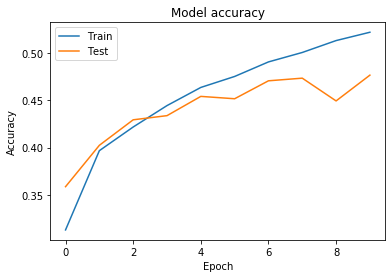

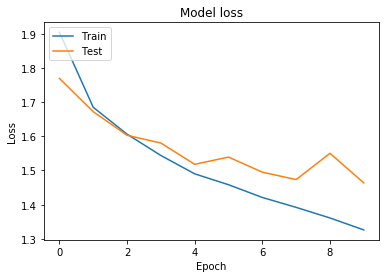

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
# model.save('simple-nn-100-epochs.h5')

# CNN

In [13]:
def convert_data_for_cnn(data):
    num_entries_in_channel = int(data.shape[1] / 3)
    data_4d = np.zeros((50000,3,32,32))
    for i in range(50000):
        x = data[i]
        r_1d = x[0:num_entries_in_channel]
        g_1d = x[num_entries_in_channel:2*num_entries_in_channel]
        b_1d = x[num_entries_in_channel*2:]

        r_2d = np.reshape(r_1d, (32,32))
        g_2d = np.reshape(g_1d, (32,32))
        b_2d = np.reshape(b_1d, (32,32))
        
        image_3d = np.zeros((3,32,32))
        image_3d[0] = r_2d
        image_3d[1] = g_2d
        image_3d[2] = b_2d
                
        data_4d[i] = image_3d
    print(data_4d.shape)
    data_4d = np.swapaxes(data_4d,1,3)
    data_4d = np.swapaxes(data_4d, 1,2)
    return data_4d

In [27]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [28]:
from tensorflow.keras.optimizers import RMSprop

# initiate RMSprop optimizer
opt = RMSprop(learning_rate=0.001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_26 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_27 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 15, 64)       

In [29]:
history = model.fit(convert_data_for_cnn(data), labels, validation_split=0.2, epochs=15, batch_size=64, shuffle=True)

(50000, 3, 32, 32)
Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 [==============================] - 9s 216us/sample - loss: 1.6856 - acc: 0.3912 - val_loss: 1.5828 - val_acc: 0.4421
Epoch 2/15
40000/40000 [==============================] - 8s 210us/sample - loss: 1.2557 - acc: 0.5560 - val_loss: 1.0496 - val_acc: 0.6347
Epoch 3/15
40000/40000 [==============================] - 8s 201us/sample - loss: 1.0722 - acc: 0.6244 - val_loss: 0.9986 - val_acc: 0.6467
Epoch 4/15
40000/40000 [==============================] - 8s 202us/sample - loss: 0.9639 - acc: 0.6663 - val_loss: 0.9745 - val_acc: 0.6661
Epoch 5/15
40000/40000 [==============================] - 8s 203us/sample - loss: 0.8897 - acc: 0.6904 - val_loss: 0.7867 - val_acc: 0.7274
Epoch 6/15
40000/40000 [==============================] - 8s 208us/sample - loss: 0.8394 - acc: 0.7115 - val_loss: 0.7960 - val_acc: 0.7250
Epoch 7/15
40000/40000 [==============================] - 8s 209us/sample - loss: 0.8008 - 

In [17]:
# model.save('simple-cnn-model-100-epoch.h5')

# CNN WITH SEPERABLE CONVOLUTIONS

In [24]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, DepthwiseConv2D, BatchNormalization
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, kernel_size=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size=(1,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [25]:
from tensorflow.keras.optimizers import RMSprop

# initiate RMSprop optimizer
opt = RMSprop(learning_rate=0.001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
activation_19 (Activation)   (None, 16, 16, 32)       

In [26]:
history = model.fit(convert_data_for_cnn(data), labels, validation_split=0.2, epochs=15, batch_size=64, shuffle=True)

(50000, 3, 32, 32)
Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 [==============================] - 10s 241us/sample - loss: 1.7604 - acc: 0.3531 - val_loss: 1.6760 - val_acc: 0.3864
Epoch 2/15
40000/40000 [==============================] - 10s 240us/sample - loss: 1.4378 - acc: 0.4751 - val_loss: 1.3790 - val_acc: 0.4947
Epoch 3/15
40000/40000 [==============================] - 9s 223us/sample - loss: 1.2946 - acc: 0.5340 - val_loss: 1.2485 - val_acc: 0.5551
Epoch 4/15
40000/40000 [==============================] - 9s 227us/sample - loss: 1.2038 - acc: 0.5702 - val_loss: 1.1674 - val_acc: 0.5835
Epoch 5/15
40000/40000 [==============================] - 9s 225us/sample - loss: 1.1440 - acc: 0.5915 - val_loss: 1.1186 - val_acc: 0.6060
Epoch 6/15
40000/40000 [==============================] - 9s 221us/sample - loss: 1.0956 - acc: 0.6085 - val_loss: 1.0690 - val_acc: 0.6197
Epoch 7/15
40000/40000 [==============================] - 9s 224us/sample - loss: 1.0521 